In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

Using TensorFlow backend.


In [2]:
np.random.seed(1120)

In [3]:
data = pd.read_csv('./data/AT.dat', delimiter="\t",
                   skiprows=[0], names=["k","r","x","A[k,r,x]"])
print(data.head())
data = data.to_numpy()

# Use first 8,056 points as training/validation and rest as test set.
train_data = data[0:8056]
test_data = data[8056:]

       k         r         x  A[k,r,x]
0  0.001  0.010817 -0.973907  1.009217
1  0.001  0.010817 -0.679410  1.009143
2  0.001  0.010817 -0.148874  1.009077
3  0.001  0.010817  0.148874  1.009077
4  0.001  0.010817  0.679410  1.009142


### Implementation
Now, we have a fair understanding of what GA is and how it works. Next, let’s get to coding.

We will use wind power forecast data, which is available at the following link. It consists of normalized (between zero and one) wind power measurements from seven wind farms. To keep things simple, we will use first wind farm data (column named wp1) but I encourage the reader to experiment and extend the code to forecast energy for all seven, wind farms.

Let’s import required packages, load the dataset and define two helper functions. The first method prepare_dataset will segment the data into chunks to create X, Y pair for model training. The X will the wind power values from the past (e.g. 1 to t-1) and Y will be future value at time t. The second method train_evaluate perform three things, 1) decoding GA solution to get window size and number of units. 2) Prepare the dataset using window size found by GA and divide into train and validation set, and 3) train LSTM model, calculate RMSE on validation set and return it as a fitness score of the current GA solution.

In [4]:
data[:,1].shape
data[:,0:3].shape

(8556, 3)

In [5]:
np.zeros(11)[6:11]

array([0., 0., 0., 0., 0.])

In [27]:
def prepare_dataset(data):
    X, Y = np.empty((0)), np.empty((0))
    X = data[:,0:3]
    Y = data[:,3]  
    return X, Y

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    deep_size_bits = BitArray(ga_individual_solution[0:3])
    num_units_bits = BitArray(ga_individual_solution[3:8])
    learning_rate_bits = BitArray(ga_individual_solution[8:12])
    batch_size_bits = BitArray(ga_individual_solution[12:14])
    epochs_bits = BitArray(ga_individual_solution[14:])
    
    deep_size = deep_size_bits.uint +2
    num_units = num_units_bits.uint +1
    learning_rate = (learning_rate_bits.uint+1)*10**(-4)
    batch_size = 2**(batch_size_bits.uint +1)
    epochs = (epochs_bits.uint +1)*50
    
    print('\nDeep Size: ', deep_size, ', Num of Units: ', num_units, ', Learning rate: ', learning_rate)
    print('Batch Size: ', batch_size, ", Num of Epochs: ", epochs)
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data)
    X_train, X_test, y_train, y_test = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    model = keras.Sequential()
    model.add(keras.Input(shape=(3,)))
    model.add(layers.Dense(num_units, input_shape=(3,)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    
    for i in range(deep_size):        
        model.add(layers.Dense(num_units, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(optimizer=optimizer,loss='mean_squared_error')
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=8,
                                   restore_best_weights=True)]
    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=epochs, callbacks=callbacks, batch_size=batch_size, shuffle=True)
    y_pred = model.predict(X_test)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

A continuación, use la paquetería DEAP para definir las cosas para ejecutar GA. Usaremos una representación binaria para la solución de longitud diez. Se inicializará aleatoriamente utilizando la distribución de Bernoulli. Del mismo modo, se utiliza el crossover ordenado, la mutación aleatoria y la selección de la rueda de la ruleta. Los valores del parámetro GA se inicializan arbitrariamente; Te sugerimos que juegues con diferentes configuraciones.



In [28]:
population_size = 5
num_generations = 4
gene_length = 15

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, 
                        ngen = num_generations, verbose = True)

C:\Users\Joshu\.conda\envs\tensorflow\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Joshu\.conda\envs\tensorflow\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Deep Size:  5 , Num of Units:  12 , Learning rate:  0.0005
Batch Size:  4 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 41.6328 - val_loss: 0.0924
Epoch 2/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 83.7940 - val_loss: 0.1151
Epoch 3/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.0848 - val_loss: 0.0450
Epoch 4/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.0497 - val_loss: 0.1312
Epoch 5/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 9.1879 - val_loss: 0.0121
Epoch 6/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.0375 - val_loss: 0.0872
Epoch 7/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 6.8655 - val_loss: 0.0054
Epoch 8/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.0040 - val_loss: 0.0017
Epoch 

6444/6444 [==============================] - 3s 535us/sample - loss: 0.0075 - val_loss: 0.0013
Epoch 23/50
6444/6444 [==============================] - 3s 485us/sample - loss: 0.0035 - val_loss: 8.3438e-04
Validation RMSE:  0.021518602742485935 


Deep Size:  7 , Num of Units:  22 , Learning rate:  0.0013000000000000002
Batch Size:  8 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 10s 1ms/sample - loss: 37.2968 - val_loss: 0.1885
Epoch 2/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.7595 - val_loss: 0.0391
Epoch 3/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0230 - val_loss: 0.0114
Epoch 4/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0133 - val_loss: 0.0057
Epoch 5/50
6444/6444 [==============================] - 6s 977us/sample - loss: 0.0141 - val_loss: 0.0034
Epoch 6/50
6444/6444 [==============================] - 6s 876us/sampl

6444/6444 [==============================] - 5s 804us/sample - loss: 5.8182e-04 - val_loss: 4.8999e-04
Epoch 20/50
6444/6444 [==============================] - 5s 819us/sample - loss: 5.4347e-04 - val_loss: 4.8618e-04
Epoch 21/50
6444/6444 [==============================] - 5s 813us/sample - loss: 5.4845e-04 - val_loss: 5.0401e-04
Epoch 22/50
6444/6444 [==============================] - 5s 809us/sample - loss: 5.4979e-04 - val_loss: 6.5162e-04
Epoch 23/50
6444/6444 [==============================] - 5s 808us/sample - loss: 5.6484e-04 - val_loss: 5.3084e-04
Epoch 24/50
6444/6444 [==============================] - 5s 804us/sample - loss: 6.5651e-04 - val_loss: 6.2946e-04
Epoch 25/50
6444/6444 [==============================] - 5s 811us/sample - loss: 0.2038 - val_loss: 0.0011
Epoch 26/50
6444/6444 [==============================] - 5s 808us/sample - loss: 0.0018 - val_loss: 5.9841e-04
Epoch 27/50
6444/6444 [==============================] - 5s 820us/sample - loss: 5.4497e-04 - val_loss: 

Epoch 10/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 5.4880e-04 - val_loss: 4.7558e-04
Epoch 11/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 4.8155e-04 - val_loss: 4.4082e-04
Epoch 12/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.0874 - val_loss: 0.0010
Epoch 13/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 6.4395e-04 - val_loss: 6.3759e-04
Epoch 14/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 4.5117e-04 - val_loss: 3.8850e-04
Epoch 15/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.0019 - val_loss: 9.9070e-04
Epoch 16/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 8.9624e-04 - val_loss: 5.0173e-04
Epoch 17/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 4.1184e-04 - val_loss: 3.3302e-04
Epoch 18/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 3.2916e-04 

6444/6444 [==============================] - 10s 2ms/sample - loss: 4.2684e-04 - val_loss: 3.8757e-04
Epoch 11/100
6444/6444 [==============================] - 10s 1ms/sample - loss: 5.5910e-04 - val_loss: 4.1605e-04
Epoch 12/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 4.3950e-04 - val_loss: 5.3771e-04
Epoch 13/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 6.0208e-04 - val_loss: 3.0137e-04
Epoch 14/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 3.3752e-04 - val_loss: 2.9158e-04
Epoch 15/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 3.6993e-04 - val_loss: 3.4807e-04
Epoch 16/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 7.5127e-04 - val_loss: 5.5396e-04
Epoch 17/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 5.2820e-04 - val_loss: 4.2573e-04
Epoch 18/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 4.1951e-04 -

La solución K mejor encontrada a través de GA se puede ver fácilmente usando tools.selBest(population,k = 1). Después, la configuración óptima se puede utilizar para entrenar en el conjunto de entrenamiento completo y probarlo en el conjunto de prueba de espera.

In [29]:
# Guarda las mejores N solutions - (1, para k=1)
best_individuals = tools.selBest(population,k = 1)
best_deep_size = None
best_num_units = None
best_learning_rate = None
best_batch_size = None
best_epochs = None

for bi in best_individuals:
    deep_size_bits = BitArray(bi[0:3])
    num_units_bits = BitArray(bi[3:8])
    learning_rate_bits = BitArray(bi[8:12])
    batch_size_bits = BitArray(bi[12:14])
    epochs_bits = BitArray(bi[14:])
    
    best_deep_size = deep_size_bits.uint +2
    best_num_units = num_units_bits.uint +1
    best_learning_rate = (learning_rate_bits.uint + 1)*10**(-4)
    best_batch_size= 2**(batch_size_bits.uint +1)
    best_epochs= (epochs_bits.uint +1)*50
    print('\nDeep Size: ', best_deep_size, ', Num of Units: ', best_num_units, ', Learning rate: ', best_learning_rate)
    print('Batch Size: ', best_batch_size, ", Num of Epochs: ", best_epochs)


Deep Size:  4 , Num of Units:  11 , Learning rate:  0.0013000000000000002
Batch Size:  4 , Num of Epochs:  100


In [30]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set
X_train,y_train = prepare_dataset(train_data)
X_test, y_test = prepare_dataset(test_data)

model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(best_num_units, input_shape=(3,)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)

for i in range(best_deep_size):        
    model.add(layers.Dense(best_num_units, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

optimizer = keras.optimizers.Adam(learning_rate=best_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
model.compile(optimizer=optimizer, loss='mean_squared_error')
# callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
#                                    min_delta=1e-4,
#                                    patience=3,
#                                    restore_best_weights=True)]
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
#                     epochs=best_epochs, callbacks=callbacks, batch_size=best_batch_size, shuffle=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=best_epochs, batch_size=best_batch_size, shuffle=True)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: ', rmse)

Train on 8056 samples, validate on 500 samples
Epoch 1/100
8056/8056 [==============================] - 13s 2ms/sample - loss: 24.6044 - val_loss: 0.0044
Epoch 2/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 0.4576 - val_loss: 0.0037
Epoch 3/100
8056/8056 [==============================] - 7s 915us/sample - loss: 0.6582 - val_loss: 0.0013
Epoch 4/100
8056/8056 [==============================] - 8s 1ms/sample - loss: 0.2455 - val_loss: 0.0026
Epoch 5/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 0.0984 - val_loss: 0.0013
Epoch 6/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 0.9212 - val_loss: 0.0036
Epoch 7/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 0.0012 - val_loss: 0.0039
Epoch 8/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 5.5711e-04 - val_loss: 0.0020
Epoch 9/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 0.0028 - val_loss: 0

Epoch 74/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 4.8865e-04 - val_loss: 0.0011
Epoch 75/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 3.0691e-04 - val_loss: 0.0017
Epoch 76/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 2.9922e-04 - val_loss: 8.6876e-04
Epoch 77/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 2.6610e-04 - val_loss: 9.2706e-04
Epoch 78/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 2.3600e-04 - val_loss: 0.0010
Epoch 79/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 2.3862e-04 - val_loss: 0.0013
Epoch 80/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 2.4456e-04 - val_loss: 0.0011
Epoch 81/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 2.6850e-04 - val_loss: 9.5362e-04
Epoch 82/100
8056/8056 [==============================] - 11s 1ms/sample - loss: 2.2960e-04 - val_lo

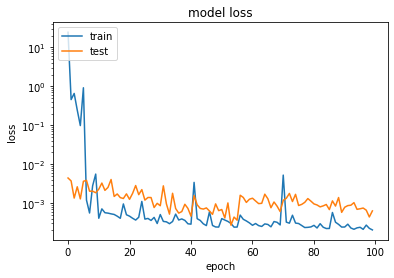

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.legend(['train', 'test'], loc='upper left')
plt.show()